## Import the data and change cate data into dummies.

damage_grade    uint8
dtype: object


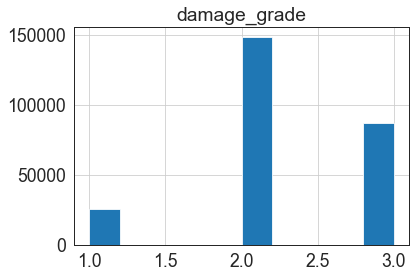

In [106]:
%reset -f
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.metrics import make_scorer
import time
from lightgbm import LGBMClassifier, plot_importance 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from scipy.stats.mstats import winsorize

train_values = pd.read_csv('./Richters_Predictor_Modeling_Earthquake_Damage_-_Train_Values.csv', 
                            index_col='building_id')
#print(train_values.dtypes)
#print(train_values.describe())

train_labels = pd.read_csv('./Richters_Predictor_Modeling_Earthquake_Damage_-_Train_Labels.csv', 
                            index_col='building_id').astype(np.uint8)
train_labels.hist()
print(train_labels.dtypes)
test_values = pd.read_csv('./test_values.csv', 
                            index_col='building_id')
train_values = pd.get_dummies(train_values)                            
test_values = pd.get_dummies(test_values)
#print(train_values.describe())

##Data Cleaning with missing data handling(we dont see any), outliers(found 1390 with age 999??), Duplication(we found some and removed)
Instances amount drop from 260601 to 248282

In [107]:
# Data cleaning for the whole datasets.

print(train_values.shape)
print(train_labels.shape)

# Part 1: Missing data:
for col in train_values.columns:
    pct_missing = np.mean(train_values[col].isnull())
    if pct_missing != 0:
        print('Instances dataset has {} with {}% missing values'.format(col, round(pct_missing*100)))

for col in train_labels.columns:
    pct_missing = np.mean(train_labels[col].isnull())
    if pct_missing != 0:
        print('Targets dataset has {} - {}% missing values'.format(col, round(pct_missing*100)))

# Part 2: Outliers:
print(train_values.describe())
## age= 995 looks to be outlier

"""train_values['age'].hist(bins=100)
upper = 300
train_values['age'].clip(upper =upper, inplace = True)
test_values['age'].clip(upper =upper, inplace = True)
train_values['age'].hist(bins=50)
print(train_values.shape)
print(train_labels.shape)"""
names = ["age", "area_percentage", "height_percentage"]
for name in names:
    #train_values[name].hist(bins=50)
    data = train_values[name]
    winsorized_data = winsorize(data,(0, 0.01))
    train_values[name] = winsorized_data
    #train_values[name].hist(bins=50)


# Will do the same to submission values

#Part 3 Duplication:
# There are 260601-248282 instances are duplicated:
# Before (260601, 68)
# After (248282, 68)
train_values['damage_grade'] = train_labels['damage_grade']
train_values.drop_duplicates(inplace=True)
train_labels = train_values.iloc[:,-1:]
train_values = train_values.iloc[:,:-1]

print(train_values.shape)
print(train_labels.shape)
train_values.describe()


(260601, 68)
(260601, 1)
       geo_level_1_id  geo_level_2_id  geo_level_3_id  count_floors_pre_eq  \
count   260601.000000   260601.000000   260601.000000        260601.000000   
mean        13.900353      701.074685     6257.876148             2.129723   
std          8.033617      412.710734     3646.369645             0.727665   
min          0.000000        0.000000        0.000000             1.000000   
25%          7.000000      350.000000     3073.000000             2.000000   
50%         12.000000      702.000000     6270.000000             2.000000   
75%         21.000000     1050.000000     9412.000000             2.000000   
max         30.000000     1427.000000    12567.000000             9.000000   

                 age  area_percentage  height_percentage  \
count  260601.000000    260601.000000      260601.000000   
mean       26.535029         8.018051           5.434365   
std        73.565937         4.392231           1.918418   
min         0.000000         1.0

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,...,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
count,248192.000000,248192.000000,248192.000000,248192.000000,248192.000000,248192.000000,248192.000000,248192.000000,248192.000000,248192.000000,...,248192.000000,248192.000000,248192.000000,248192.000000,248192.000000,248192.000000,248192.000000,248192.000000,248192.000000,248192.000000
mean,13.910058,700.703081,6256.817077,2.128783,21.828846,7.982719,5.407007,0.090063,0.756616,0.034675,...,0.000185,0.000153,0.000641,0.022358,0.001394,0.014666,0.021298,0.005862,0.962400,0.010439
std,8.047919,412.937281,3644.350770,0.733188,19.936390,3.866632,1.782867,0.286273,0.429126,0.182955,...,0.013613,0.012373,0.025303,0.147844,0.037311,0.120212,0.144376,0.076342,0.190227,0.101639
min,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,349.000000,3073.000000,2.000000,10.000000,5.000000,4.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,12.000000,701.000000,6264.000000,2.000000,15.000000,7.000000,5.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,21.000000,1050.000000,9411.000000,2.000000,30.000000,10.000000,6.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,30.000000,1427.000000,12567.000000,9.000000,100.000000,23.000000,11.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [108]:
train_values['volume_percentage'] = train_values.area_percentage * train_values.height_percentage
train_values['thin_tall'] = train_values.height_percentage / train_values.area_percentage
test_values['volume_percentage'] = test_values.area_percentage * test_values.height_percentage
test_values['thin_tall'] = test_values.height_percentage / test_values.area_percentage

In [55]:
# ****
# TEST COMBINING SOME CATEG BIN FEATURES
df_superstructure = train_values.filter(like='has_superstructure_')
df_superstructure = df_superstructure + 1 # transforming zeros
#df_superstructure[(df_superstructure > 1)].count(axis=1) # count values > 1 (originally 0's) in each row
df_superstructure['superstructure'] = df_superstructure.sum(axis = 1) - 10
# df_superstructure.head()

df_secondary_use = train_values.filter(like='has_secondary_use')
df_secondary_use = df_secondary_use + 1 # transforming zeros
# df_secondary_use[(df_secondary_use > 1)].count(axis=1) # count values > 1 (originally 0's) in each row
df_secondary_use['secondary'] = df_secondary_use.sum(axis = 1) - 10 # 11 cols - 1
# df_secondary_use.head(40)

df_superstructure_test = test_values.filter(like='has_superstructure_')
df_superstructure_test = df_superstructure_test + 1 # transforming zeros
#df_superstructure[(df_superstructure > 1)].count(axis=1) # count values > 1 (originally 0's) in each row
df_superstructure_test['superstructure'] = df_superstructure_test.sum(axis = 1) - 10
# df_superstructure.head()

df_secondary_use_test = test_values.filter(like='has_secondary_use')
df_secondary_use_test = df_secondary_use_test + 1 # transforming zeros
# df_secondary_use[(df_secondary_use > 1)].count(axis=1) # count values > 1 (originally 0's) in each row
df_secondary_use_test['secondary'] = df_secondary_use_test.sum(axis = 1) - 10 # 11 cols - 1
# df_secondary_use.head(40)


# 8. add more features:  f1-score: # 0.6801458001892986 (20)   0.6888052036973639 (50)  0.6917252351128743 (100)  0.6922286888052037 (200) 0.6928731095313853 (500)
# Some improvements...
train_values['volume_percentage'] = train_values.area_percentage * train_values.height_percentage
train_values = train_values[['geo_level_1_id', 
                              'geo_level_2_id', 
                              'geo_level_3_id', 
                              'count_floors_pre_eq', 
                              'age',
                              'land_surface_condition_n', 'land_surface_condition_o', 'land_surface_condition_t',
                              'foundation_type_h', 'foundation_type_i', 'foundation_type_r', 'foundation_type_u', 'foundation_type_w',
                              'count_families',
                              'area_percentage', 'height_percentage', 'volume_percentage'
                              ]]

train_values['superstructure'] = df_superstructure['superstructure']
train_values['secondary'] = df_secondary_use['secondary']

test_values['volume_percentage'] = test_values.area_percentage * test_values.height_percentage
test_values = test_values[['geo_level_1_id', 
                              'geo_level_2_id', 
                              'geo_level_3_id', 
                              'count_floors_pre_eq', 
                              'age',
                              'land_surface_condition_n', 'land_surface_condition_o', 'land_surface_condition_t',
                              'foundation_type_h', 'foundation_type_i', 'foundation_type_r', 'foundation_type_u', 'foundation_type_w',
                              'count_families',
                              'area_percentage', 'height_percentage', 'volume_percentage'
                              ]]

test_values['superstructure'] = df_superstructure_test['superstructure']
test_values['secondary'] = df_secondary_use_test['secondary']

# 9. add more features:  f1-score: # 0.6799041424169805 (20)   0.688241335561955  (50)  0.6881607829711823 (100)
# This is worse than # 8
# train_values2 = train_values[['geo_level_1_id', 
#                               'geo_level_2_id', 
#                               'geo_level_3_id', 
#                               'count_floors_pre_eq', 
#                               'age',
#                               'land_surface_condition_n', 'land_surface_condition_o', 'land_surface_condition_t',
#                               'foundation_type_h', 'foundation_type_i', 'foundation_type_r', 'foundation_type_u', 'foundation_type_w',
#                               'count_families',
#                             'plan_configuration_a', 'plan_configuration_c', 'plan_configuration_d', 
#                             'plan_configuration_f', 'plan_configuration_m', 'plan_configuration_n', 
#                             'plan_configuration_o', 'plan_configuration_q',  'plan_configuration_s', 
#                             'plan_configuration_u'                              
#                               ]]

# train_values2['superstructure'] = df_superstructure['superstructure']
# train_values2['secondary'] = df_secondary_use['secondary'] 

# train_values2['volume_percentage'] = train_values.area_percentage * train_values.height_percentage


In [110]:
X_train, X_test, y_train, y_test = train_test_split(train_values,train_labels["damage_grade"],test_size=0.25,random_state=1000)

In [5]:

########### NearMiss Alforithm to handle imbalanced data.
print("Before Undersampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before Undersampling, counts of label '2': {} \n".format(sum(y_train == 2)))
print("Before Undersampling, counts of label '3': {} \n".format(sum(y_train == 3)))
sm = SMOTE(n_jobs=-1)
X_train, b = sm.fit_resample(X_train, y_train.values)
y_train = pd.Series(b, index=X_train.index)
print("After Undersampling, counts of label '1': {}".format(sum(y_train == 1)))
print("After Undersampling, counts of label '2': {} \n".format(sum(y_train == 2)))
print("After Undersampling, counts of label '3': {} \n".format(sum(y_train == 3)))
#############

Before Undersampling, counts of label '1': 18225
Before Undersampling, counts of label '2': 106406 

Before Undersampling, counts of label '3': 61580 

After Undersampling, counts of label '1': 106406
After Undersampling, counts of label '2': 106406 

After Undersampling, counts of label '3': 106406 



In [ ]:
## Feature interaction. Data pair up for selection: {height_percentage/area_percentage}, {height_percentage*age}, {height_percentage*(has_superstructure_stone_flag+ )}

## Data transerfing, normalize all the columns in train dataset, and use the same model for test dataset.(Will need to add it for submission dataset as well.)

[ 0.14509422  0.33242179 -0.15146088  0.36481205  0.64387626  0.04761789
 -1.11354034]
[ 0.14509422  0.33242179 -0.15146088  0.36481205  0.64387626  0.04761789
 -1.11354034]


array([[<AxesSubplot:title={'center':'geo_level_1_id'}>,
        <AxesSubplot:title={'center':'geo_level_2_id'}>,
        <AxesSubplot:title={'center':'geo_level_3_id'}>,
        <AxesSubplot:title={'center':'count_floors_pre_eq'}>,
        <AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'area_percentage'}>,
        <AxesSubplot:title={'center':'height_percentage'}>,
        <AxesSubplot:title={'center':'has_superstructure_adobe_mud'}>],
       [<AxesSubplot:title={'center':'has_superstructure_mud_mortar_stone'}>,
        <AxesSubplot:title={'center':'has_superstructure_stone_flag'}>,
        <AxesSubplot:title={'center':'has_superstructure_cement_mortar_stone'}>,
        <AxesSubplot:title={'center':'has_superstructure_mud_mortar_brick'}>,
        <AxesSubplot:title={'center':'has_superstructure_cement_mortar_brick'}>,
        <AxesSubplot:title={'center':'has_superstructure_timber'}>,
        <AxesSubplot:title={'center':'has_superstructure_bamboo'}>,
     

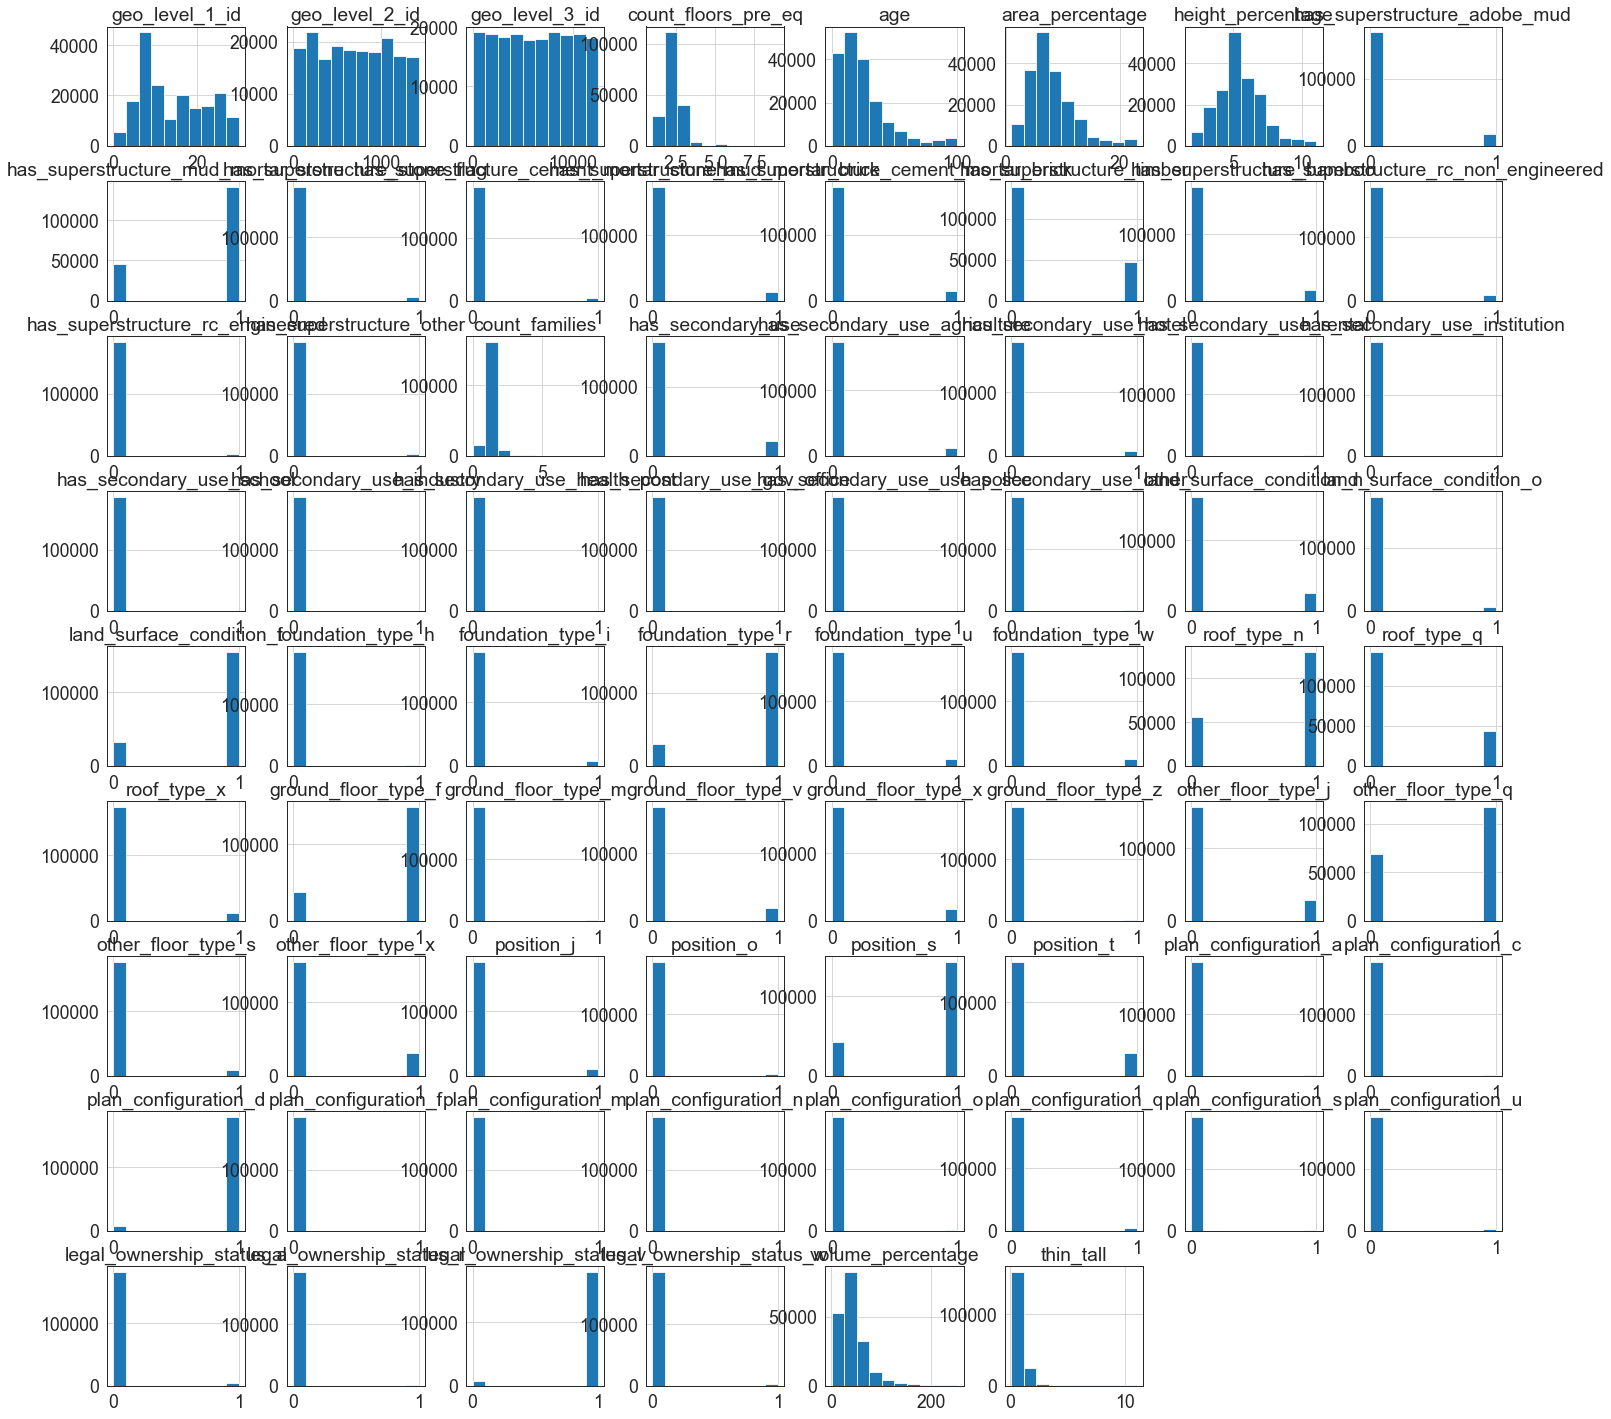

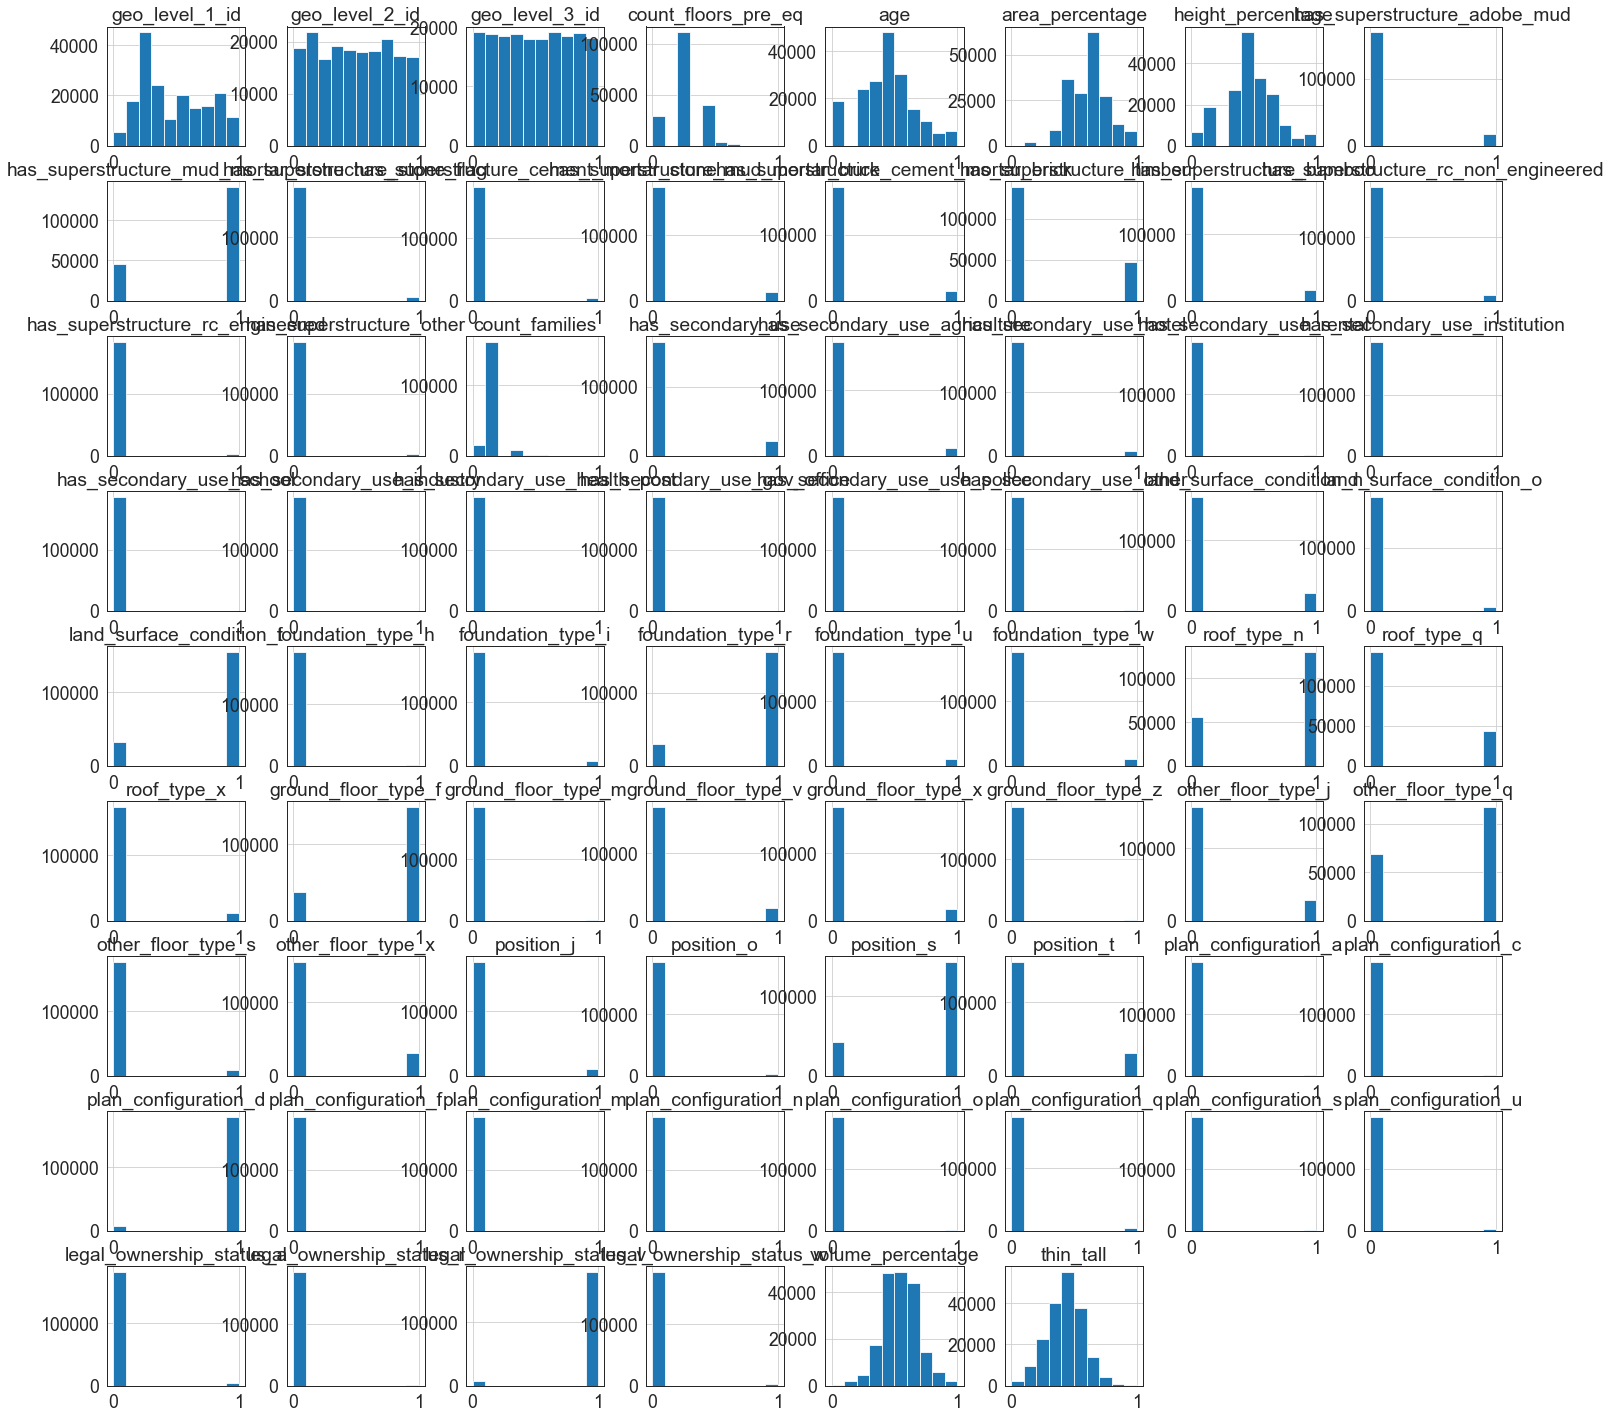

In [111]:
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
#sns.displot(data=train_labels, x="damage_grade", kind="hist", bins = 100, aspect = 1.5)
#for key in train_values.keys():
#    train_values.hist(column=key, bins=100)
#X_train.hist(figsize=[25,25])
pt = PowerTransformer()
mmscal = MinMaxScaler()

columns_transfer = X_train.columns[3:7].append(X_train.columns[18:19].append(X_train.columns[-2:]))
#columns_transfer = X_train.columns
#columns_transfer = X_train.columns[0:5].append(X_train.columns[-5:])
pt.fit(X_train[columns_transfer])
print("{}".format(pt.lambdas_))
X_train[columns_transfer].hist(figsize=[25,25])
X_train[columns_transfer] = pd.DataFrame(pt.transform(X_train[columns_transfer]), columns = columns_transfer, index=X_train.index)
X_test[columns_transfer] = pd.DataFrame(pt.transform(X_test[columns_transfer]), columns = columns_transfer, index=X_test.index)
test_values[columns_transfer] = pd.DataFrame(pt.transform(test_values[columns_transfer]), columns = columns_transfer, index=test_values.index)
X_train[columns_transfer].hist(figsize=[25,25])
#Save memory convert float64 to float32
columns_transfer = X_train.columns[0:7].append(X_train.columns[18:19].append(X_train.columns[-2:]))
#columns_transfer = X_train.columns
X_train[columns_transfer] = pd.DataFrame(mmscal.fit_transform(X_train[columns_transfer]), columns = columns_transfer, index=X_train.index)
X_test[columns_transfer] = pd.DataFrame(mmscal.transform(X_test[columns_transfer]), columns = columns_transfer, index=X_test.index)
test_values[columns_transfer] = pd.DataFrame(mmscal.transform(test_values[columns_transfer]), columns = columns_transfer, index=test_values.index)
#X_test[X_test.select_dtypes(np.float64).columns] = X_test.select_dtypes(np.float64).astype(np.float32)
#test_values[test_values.select_dtypes(np.float64).columns] = test_values.select_dtypes(np.float64).astype(np.float32)

#Save memory convert float64 to float16
X_train[X_train.select_dtypes(np.float64).columns] = X_train.select_dtypes(np.float64).astype(np.float16)
X_test[X_test.select_dtypes(np.float64).columns] = X_test.select_dtypes(np.float64).astype(np.float16)
test_values[test_values.select_dtypes(np.float64).columns] = test_values.select_dtypes(np.float64).astype(np.float16)

print("{}".format(pt.lambdas_))
#X_train.hist(figsize=[25,25])

# if we do the box-cox sepretely, the results show worse cause they are not following the exact same transiction.

array([[<AxesSubplot:title={'center':'count_families'}>,
        <AxesSubplot:title={'center':'volume_percentage'}>],
       [<AxesSubplot:title={'center':'thin_tall'}>, <AxesSubplot:>]],
      dtype=object)

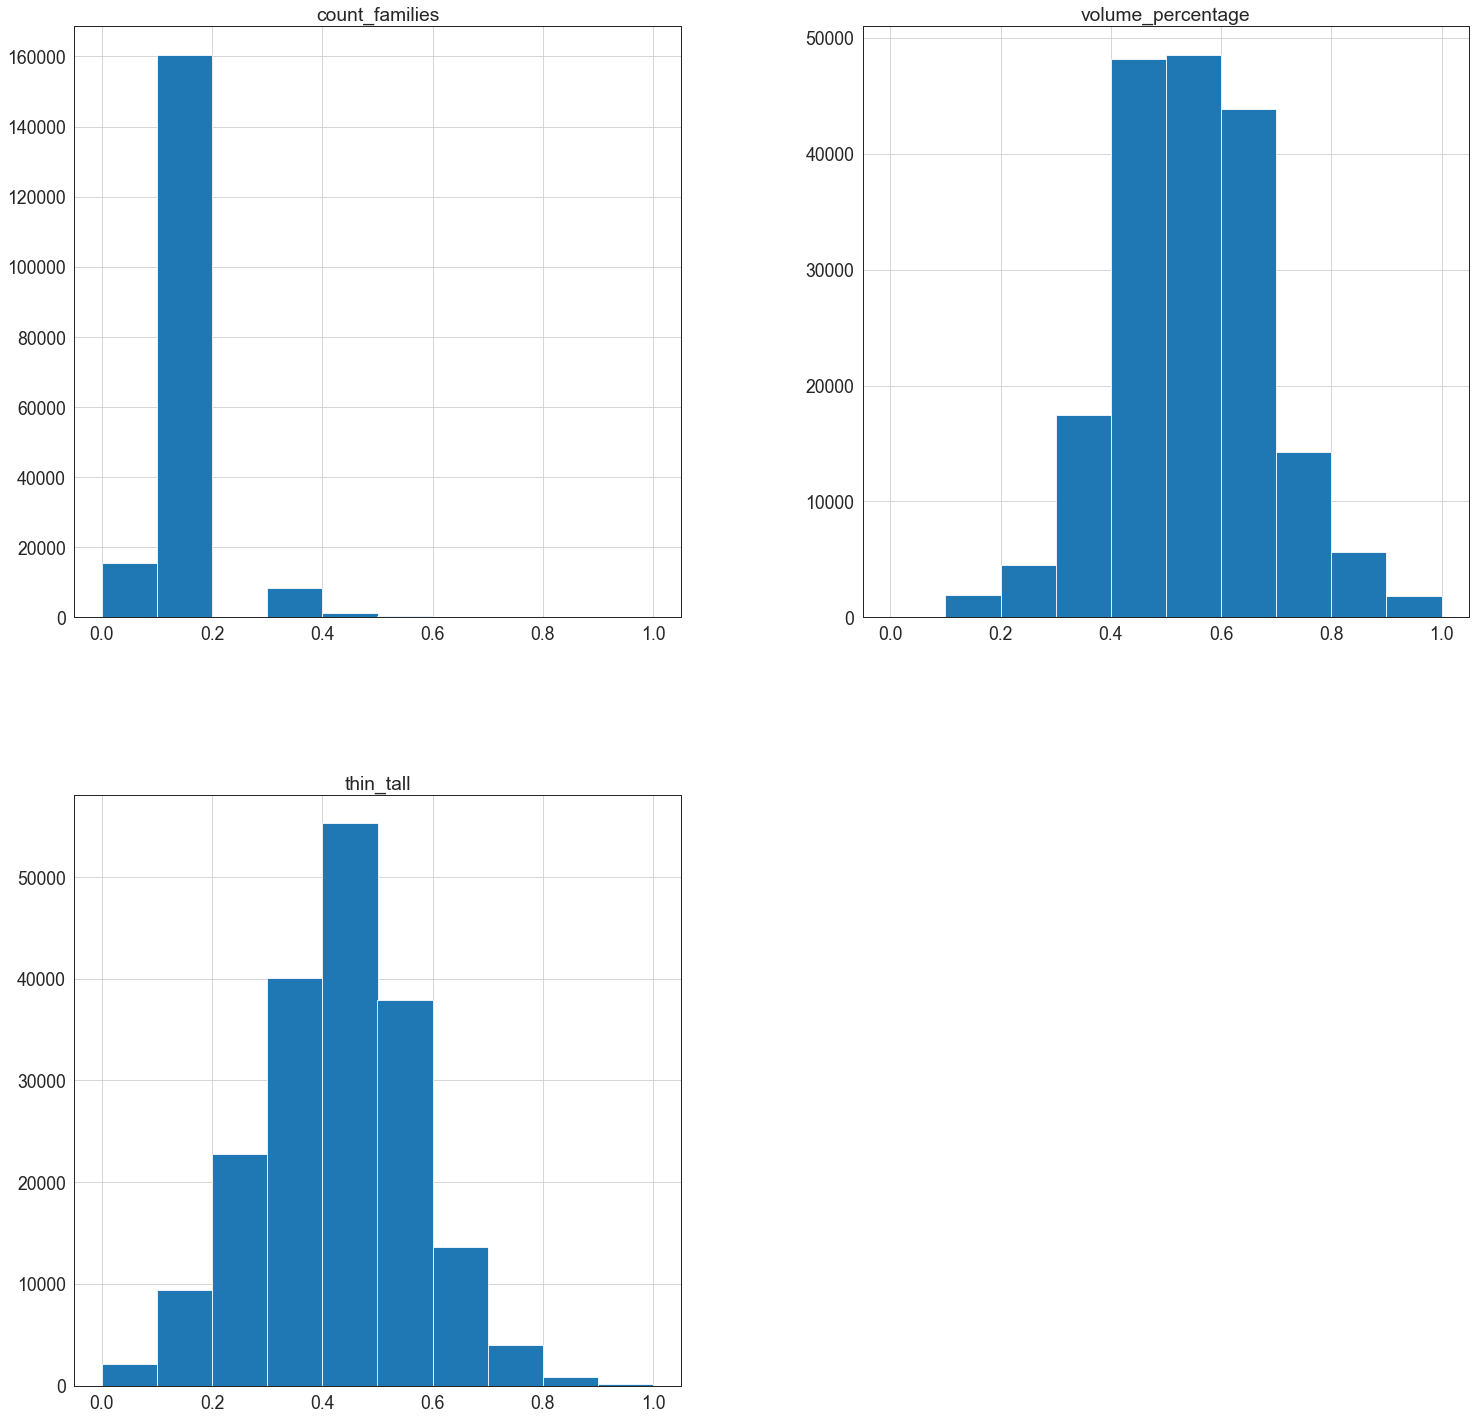

In [112]:
X_train[X_train.columns[18:19].append(X_train.columns[-2:])].hist(figsize=[25,25])

In [ ]:
# Find all the possible 2-degree interactions and go through lasso to filter out part of it.
from sklearn import preprocessing as pp
poly = pp.PolynomialFeatures(2)
a = poly.fit_transform(X_train)
#poly.get_feature_names(X_train.columns)
reg = LassoCV(n_jobs=4, cv=5, selection='random')
reg.fit(a, y_train)
coef = pd.DataFrame(reg.coef_, index = poly.get_feature_names(X_train.columns))

picked = []
removed = []
for i in coef.index:
    if coef.at[i,0] != 0:
        picked.append(i)
    else:
        removed.append(i)

print("Lasso picked {} features:{}".format(len(picked), picked))
print("Lasso removed {} features:{}".format(len(removed), removed))

In [ ]:
#Using PCA to furthur filter out part of the features. And test with randomforest.
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
X = pd.DataFrame(a, columns = poly.get_feature_names(X_train.columns), index=X_train.index)
X = X[picked]
#pca = PCA(n_components=50)
#pca_fit = pca.fit(X)
#print("Explained Variance: %s" % pca_fit.explained_variance_ratio_)
#print(pca_fit.components_)
#X = pca_fit.transform(X)
X_2 = pd.DataFrame(poly.fit_transform(X_test), columns = poly.get_feature_names(X_test.columns), index=X_test.index)
X_2 = X_2[picked]
#X_2 = pca_fit.transform(X_2)



In [73]:
## try Lasso to remove some of the features
reg = LassoCV(n_jobs=-1, cv=5)
reg.fit(X_train, y_train)
coef = pd.DataFrame(reg.coef_, index = train_values.columns)

picked = []
removed = []
for i in coef.index:
    if coef.at[i,0] != 0:
        picked.append(i)
    else:
        removed.append(i)

print("Lasso picked {} features:{}".format(len(picked), picked))
print("Lasso removed {} features:{}".format(len(removed), removed))

X_train = X_train.drop(columns=removed)
X_test= X_test.drop(columns=removed)
test_values= test_values.drop(columns=removed)

Lasso picked 50 features:['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'count_floors_pre_eq', 'age', 'area_percentage', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag', 'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 'count_families', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_rental', 'has_secondary_use_other', 'land_surface_condition_n', 'land_surface_condition_o', 'foundation_type_i', 'foundation_type_r', 'foundation_type_u', 'foundation_type_w', 'roof_type_q', 'roof_type_x', 'ground_floor_type_f', 'ground_floor_type_m', 'ground_floor_type_v', 'ground_floor_type_x', 'other_floor_type_j', 'other_floor_type_q', 'other_floor_type_s', 'other_floor_type_x', 'posi

In [104]:
#Using PCA to furthur filter out part of the features. And test with randomforest.
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
pca = PCA(n_components=40)
pca_fit = pca.fit(X_train)
print("Explained Variance: %s" % pca_fit.explained_variance_ratio_)
print("Total Variance: %s" % sum(pca_fit.explained_variance_ratio_))
print(pca_fit.components_)
#X = pca_fit.transform(X)

X_train = pca.transform(X_train).astype(np.float16)
X_test = pca.transform(X_test).astype(np.float16)

Explained Variance: [0.1544653  0.09740606 0.08555296 0.06780876 0.0618463  0.05705703
 0.04775052 0.0416178  0.03999161 0.03420628 0.02575837 0.02166948
 0.02101914 0.01826717 0.01752596 0.01680713 0.01463033 0.01387664
 0.01371095 0.01257442 0.01158476 0.01111454 0.01055445 0.00965393
 0.00950858 0.0093066  0.0091365  0.00822586 0.00676007 0.00631232
 0.00495087 0.00446045 0.00437405 0.00430445 0.00382612 0.00339054
 0.00289319 0.00282454 0.00198737 0.0017711 ]
Total Variance: 0.9904824954832048
[[ 6.36898430e-02 -5.12383410e-02 -6.45254833e-03 ... -6.59827294e-04
   2.69740632e-02 -5.61814756e-02]
 [-2.18038629e-02 -2.20640495e-02 -4.11411453e-03 ... -2.76876369e-03
   5.66136340e-02  3.62016489e-02]
 [-6.54221548e-02  3.23217118e-02 -1.39075061e-02 ...  6.38335771e-03
   5.94137764e-02  3.85188327e-02]
 ...
 [-6.00210628e-03  7.59850228e-03  1.94743544e-03 ...  9.53053345e-03
  -8.42800234e-05  2.28401263e-02]
 [-1.19954492e-02 -1.34124573e-03  2.01588522e-03 ...  1.18558810e-03
  

In [103]:
a.dtype

dtype('float16')

In [105]:
# RF/estimators 100
pipe = make_pipeline(
    #PCA(n_components='mle'),
    RandomForestClassifier(max_features = None,
                            max_depth = 45,
                            min_samples_split = 3,
                            min_samples_leaf = 30,
                            n_jobs= -1))
param_grid = {
    'randomforestclassifier__n_estimators': [100]#range(200, 1000, 100)
    }
gs = GridSearchCV(pipe, param_grid, cv=5, n_jobs= -1, scoring='f1_micro')
gs.fit(X_train, y_train)
in_sample_preds = gs.predict(X_test)
print('train f1_score: {}'.format(f1_score(y_train, gs.predict(X_train), average='micro')))
print('test f1_score: {}'.format(f1_score(y_test, in_sample_preds, average='micro')))
gs.best_params_


train f1_score: 0.7546684287433385
test f1_score: 0.6724632542547705


{'randomforestclassifier__n_estimators': 100}

In [84]:
# RF/estimators Tuning
rf =     RandomForestClassifier(max_features = None,
                            #max_samples = 0.1,
                            n_jobs= -1
                            )
pipe = make_pipeline(
    #PCA(n_components='mle'),
    rf
    )
param_grid = {
    'randomforestclassifier__n_estimators': [100],#range(200, 1000, 100)
    'randomforestclassifier__max_depth': [50,55,60],
    'randomforestclassifier__min_samples_split': [3],
    'randomforestclassifier__min_samples_leaf': [8, 10, 15]
    }
gs = GridSearchCV(pipe, param_grid, n_jobs= -1, scoring='f1_micro',cv =5)
gs.fit(X_train, y_train)
in_sample_preds = gs.predict(X_test)
print('train f1_score: {}'.format(f1_score(y_train, gs.predict(X_train), average='micro')))
print('test f1_score: {}'.format(f1_score(y_test, in_sample_preds, average='micro')))
gs.best_params_

train f1_score: 0.8454285360215952
test f1_score: 0.7277179710988264


{'randomforestclassifier__max_depth': 60,
 'randomforestclassifier__min_samples_leaf': 5,
 'randomforestclassifier__min_samples_split': 3,
 'randomforestclassifier__n_estimators': 100}

In [86]:
#LGBM default
clf = LGBMClassifier(#n_estimators=1546,
                     #num_leaves=66,
                     #max_depth=10,
                     #learning_rate=0.05,
                     #random_state=2018,
                     n_jobs=-1,
                     #device='gpu',
                     #max_bin=15,
                     #gpu_use_dp='false',
                     #gpu_platform_id = 0,
                     #gpu_device_id = 1,
                     #num_gpu=3
                     )
param_grid = {
    #'randomforestclassifier__n_estimators': [500]#range(200, 1000, 100)
    }

pca = PCA(n_components=8)
pipe = make_pipeline(
    #pca,
    clf)
gs = GridSearchCV(pipe, param_grid, cv=5, n_jobs= -1, scoring='f1_micro')
start = time.time()
gs.fit(X_train,y_train)
elapsed = time.time() - start
print(f'LGBM Training ran in {elapsed:.5f} seconds')
y_pred = gs.predict(X_test)
print('train f1_score: {}'.format(f1_score(y_train, gs.predict(X_train), average='micro')))
print('f1_score: {}'.format(f1_score(y_test, y_pred, average='micro')))
gs.best_params_

LGBM Training ran in 7.62840 seconds
train f1_score: 0.7128994541937639
f1_score: 0.7076261597646525


{}

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

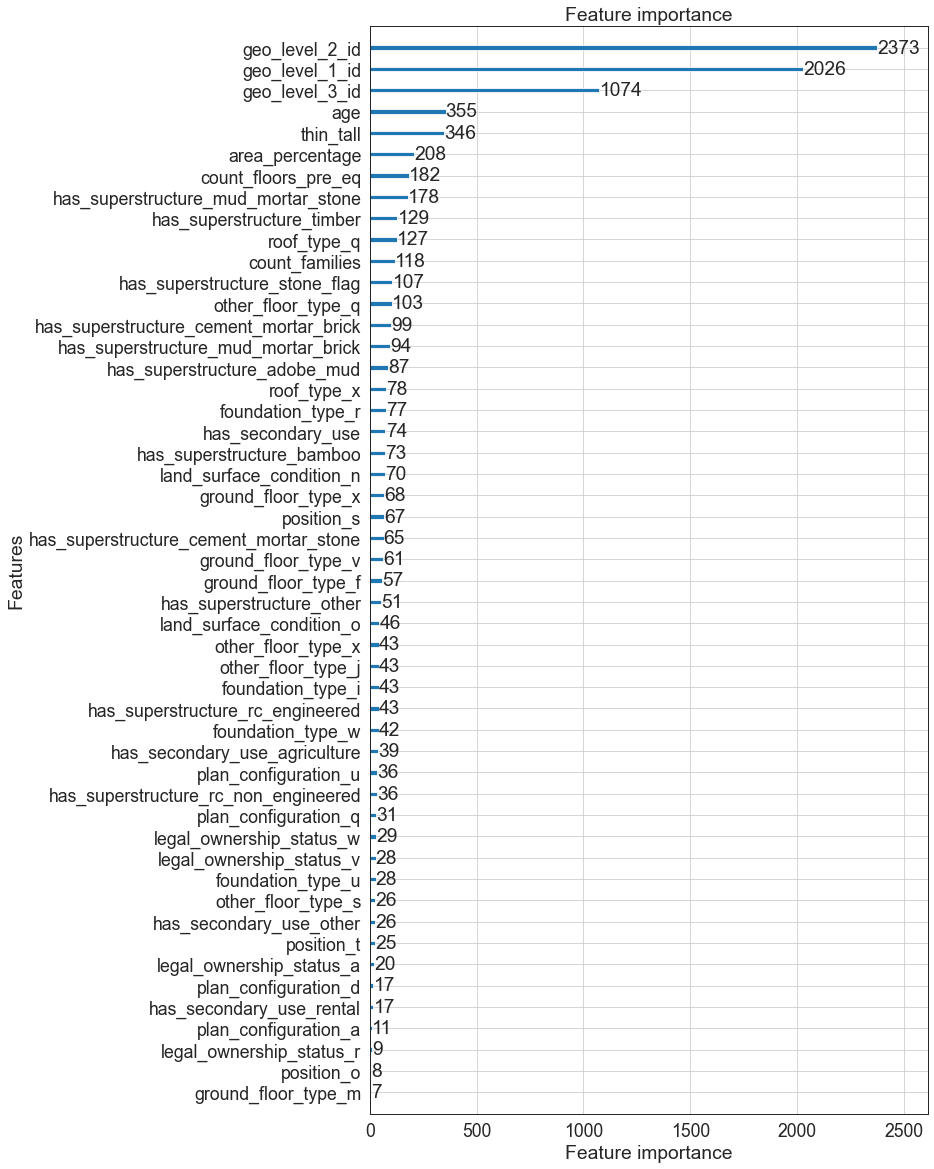

In [87]:
from lightgbm import plot_importance 
clf.fit(X_train,y_train)
plot_importance(clf, figsize=(10, 20))

In [94]:
#LGBM Turning
clf = LGBMClassifier(n_jobs= -1)
param_test ={'lgbmclassifier__num_leaves': [65,67,69], 
             #'min_child_samples': sp_randint(100, 500), 
             #'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             #'subsample': sp_uniform(loc=0.2, scale=0.8), 
             #'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             #'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             #'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
             'lgbmclassifier__learning_rate': [5e-2],
             'lgbmclassifier__n_estimators': [1700,1800],#sp_randint(1500, 2500),
             'lgbmclassifier__max_depth': [10] #sp_randint(8, 12)
             }

#pca = PCA(n_components=8)
pipe = make_pipeline(
    #pca,
    clf)
gs = GridSearchCV(pipe, param_test, cv=5, n_jobs= -1, scoring='f1_micro')
start = time.time()
gs.fit(X_train,y_train)
elapsed = time.time() - start
print(f'LGBM Training ran in {elapsed:.5f} seconds')
y_pred = gs.predict(X_test)
print('train f1_score: {}'.format(f1_score(y_train, gs.predict(X_train), average='micro')))
print('f1_score: {}'.format(f1_score(y_test, y_pred, average='micro')))
gs.best_params_


LGBM Training ran in 565.25892 seconds
train f1_score: 0.8242805648798203
f1_score: 0.7365111693013934


{'lgbmclassifier__learning_rate': 0.05,
 'lgbmclassifier__max_depth': 10,
 'lgbmclassifier__n_estimators': 1700,
 'lgbmclassifier__num_leaves': 67}

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

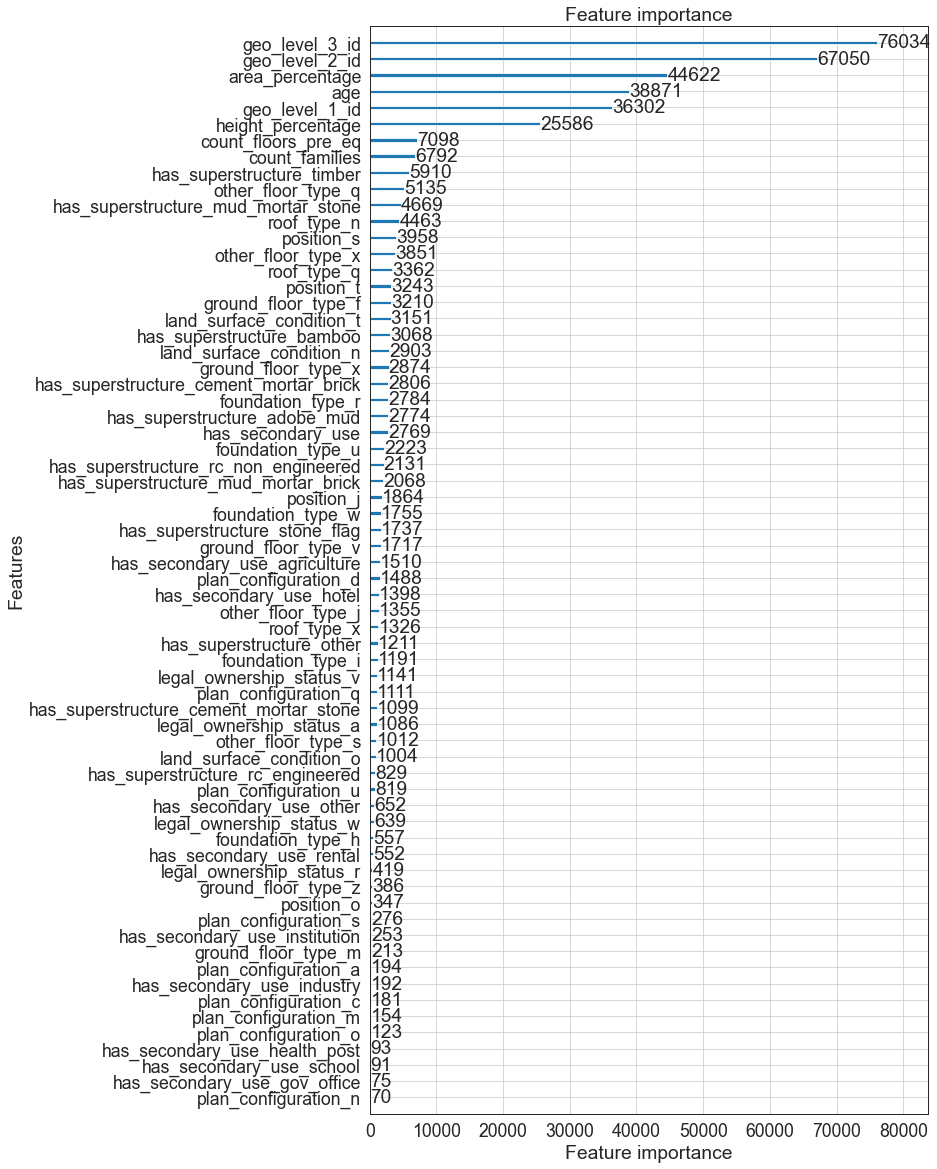

In [86]:
from lightgbm import plot_importance
clf = LGBMClassifier(
    learning_rate=5e-2,
    max_depth =10,
    n_estimators = 2000,
    num_leaves = 90,
    n_jobs= -1
)
clf.fit(X_train,y_train)
plot_importance(clf, figsize=(10, 20))

In [56]:

pipe = make_pipeline(PCA(n_components='mle'),RandomForestClassifier(random_state=2018))
param_grid = {
    'randomforestclassifier__n_estimators': [500]#range(200, 1000, 100)
    }
gs = GridSearchCV(pipe, param_grid, cv=5, n_jobs= -1, scoring='f1_micro')
gs.fit(X_train, y_train)
gs.best_params_
in_sample_preds = gs.predict(X_test)
print('train f1_score: {}'.format(f1_score(y_train, gs.predict(X_train), average='micro')))
print('test f1_score: {}'.format(f1_score(y_test, in_sample_preds, average='micro')))

train f1_score: 0.9917029828984784
test f1_score: 0.6632566756615248


In [43]:
clf = LGBMClassifier(n_estimators=1546,
                     num_leaves=66,
                     max_depth=10,
                     learning_rate=0.05,
                     #random_state=2107,
                     n_jobs=-1,
                     #device='gpu',
                     #max_bin=15,
                     #gpu_use_dp='false',
                     #gpu_platform_id = 0,
                     #gpu_device_id = 1,
                     #num_gpu=3
                     )
param_grid = {
    #'randomforestclassifier__n_estimators': [500]#range(200, 1000, 100)
    }

pca = PCA(n_components=8)
pipe = make_pipeline(
    #pca,
    clf)
gs = GridSearchCV(pipe, param_grid, cv=5, n_jobs= -1, scoring='f1_micro')
start = time.time()
gs.fit(X_train,y_train)
elapsed = time.time() - start
print(f'LGBM Training ran in {elapsed:.5f} seconds')
y_pred = gs.predict(X_test)
print('f1_score: {}'.format(f1_score(y_test, y_pred, average='micro')))
gs.best_params_

LGBM Training ran in 145.47388 seconds
f1_score: 0.7356221511007662


{}

In [61]:
pca = PCA(n_components='mle')
pca.fit(X_train,y_train)
pca.explained_variance_


array([5.95634205e-01, 3.73917699e-01, 3.27182272e-01, 2.62389633e-01,
       2.40897537e-01, 2.19990930e-01, 1.69223068e-01, 1.60897546e-01,
       1.54522071e-01, 1.31168014e-01, 9.95322101e-02, 8.41027432e-02,
       8.16986471e-02, 7.01860300e-02, 6.74045743e-02, 6.51919656e-02,
       5.58333731e-02, 5.34483064e-02, 5.21744845e-02, 4.90118419e-02,
       4.48230353e-02, 4.03692967e-02, 3.84075445e-02, 3.65547442e-02,
       3.54299700e-02, 3.20988422e-02, 2.62543726e-02, 2.18913084e-02,
       2.04602090e-02, 1.75988638e-02, 1.71017568e-02, 1.69361202e-02,
       1.47117593e-02, 1.33101416e-02, 1.18663478e-02, 1.10862014e-02,
       1.06778383e-02, 7.89515483e-03, 7.76418043e-03, 6.64937650e-03,
       6.19265550e-03, 5.48793804e-03, 5.25585585e-03, 3.78722783e-03,
       2.64555457e-03, 2.55914060e-03, 2.34617503e-03, 1.75151896e-03,
       1.32874105e-03, 1.09244075e-03, 1.08427261e-03, 6.93132545e-04,
       5.09688985e-04, 2.53468307e-04, 2.35207350e-04, 1.72232938e-04,
      

In [38]:
param_test ={'num_leaves': [60, 70, 80], 
             #'min_child_samples': sp_randint(100, 500), 
             #'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             #'subsample': sp_uniform(loc=0.2, scale=0.8), 
             #'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             #'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             #'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
             'learning_rate': [5e-2],
             'n_estimators': sp_randint(1500, 2500),
             'max_depth': sp_randint(8, 12)
             }
n_HP_points_to_test = 25

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = LGBMClassifier()
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='f1_micro',
    n_jobs = -1,
    cv=3,
    refit=True,
    verbose=True)
start = time.time()
gs.fit(X_train,y_train)
elapsed = time.time() - start
print(f'LGBM Training ran in {elapsed:.5f} seconds')
y_pred = gs.predict(X_test)
print('train f1_score: {}'.format(f1_score(y_train, gs.predict(X_train), average='micro')))
print('test f1_score: {}'.format(f1_score(y_test, y_pred, average='micro')))
gs.best_params_

Fitting 5 folds for each of 25 candidates, totalling 125 fits
LGBM Training ran in 2643.20465 seconds
train f1_score: 0.8247092872719322
test f1_score: 0.7331274753306035


{'learning_rate': 0.05,
 'max_depth': 11,
 'n_estimators': 1591,
 'num_leaves': 69}

In [50]:
print(f'train_labels shape: {train_labels}')
print(f'X_train shape: {X_train.shape}')
print(f'Train LGBM classifier ...')
clf = LGBMClassifier(n_estimators=10000,
                     num_leaves=2048,
                     max_depth=11,
                     learning_rate=0.01,
                     n_jobs=-1,
                     #device='gpu',
                     #max_bin=15,
                     #gpu_use_dp='false',
                     #gpu_platform_id = 0,
                     #gpu_device_id = 1,
                     #num_gpu=3
                     )
start = time.time()
clf.fit(X_train,y_train)
elapsed = time.time() - start
print(f'LGBM Training ran in {elapsed:.5f} seconds')
y_pred = clf.predict(X_test)
print('f1_score: {}'.format(f1_score(y_test, y_pred, average='micro')))

train_labels shape:              damage_grade
building_id              
802906                  3
28830                   2
94947                   3
590882                  2
201944                  3
...                   ...
688636                  2
669485                  3
602512                  3
151409                  2
747594                  3

[248282 rows x 1 columns]
X_train shape: (173797, 50)
Train LGBM classifier ...
LGBM Training ran in 395.32614 seconds
f1_score: 0.7213532926092502


In [50]:
print(f'train_labels shape: {train_labels}')
print(f'X_train shape: {X_train.shape}')
print(f'Train LGBM classifier ...')
clf = LGBMClassifier(n_estimators=1546,
                     num_leaves=66,
                     max_depth=10,
                     learning_rate=0.05,
                     #random_state=2107,
                     n_jobs=-1,
                     #device='gpu',
                     #max_bin=15,
                     #gpu_use_dp='false',
                     #gpu_platform_id = 0,
                     #gpu_device_id = 1,
                     #num_gpu=3
                     )
start = time.time()
clf.fit(X_train,y_train)
elapsed = time.time() - start
print(f'LGBM Training ran in {elapsed:.5f} seconds')
y_pred = clf.predict(X_test)
print('f1_score: {}'.format(f1_score(y_test, y_pred, average='micro')))


train_labels shape:              damage_grade
building_id              
802906                  3
28830                   2
94947                   3
590882                  2
201944                  3
...                   ...
688636                  2
669485                  3
602512                  3
151409                  2
747594                  3

[260601 rows x 1 columns]
X_train shape: (130300, 68)
Train LGBM classifier ...
LGBM Training ran in 14.87448 seconds
f1_score: 0.7347377307087218


In [95]:
print('train f1_score: {}'.format(f1_score(y_train, gs.predict(X_train), average='micro')))

train f1_score: 0.9889813978377072


In [ ]:
test_values = pd.read_csv('./test_values.csv', index_col='building_id')

test_values = pd.get_dummies(test_values)
predictions = gs.predict(test_values)
submission_format = pd.read_csv('./submission_format.csv', index_col='building_id')
my_submission = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)
my_submission.head()
my_submission.to_csv('submission.csv')
!head submission.csv

'head' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���
